Collect the data and see how they look. There are three sources of data, so I deal with tehm seperately and combine togather at the end.

In [1]:
import glob 
import numpy as np
import pandas as pd

import datetime
date = datetime.datetime.now().strftime('%Y%m%d')

# Collect WRA water level data
There are three kinds of data format in these WRA water level data. I'll check them one by one and merged into sub-datasets for later merging.

## Before 2019
In the folders naming 201901XXX. Collect the csv in this format/time range to build a sub-dataset by applying those pilot steps in the dirty version. In order to speed up the process, the RAM is increased to 32 GB and apply Dask to do multiprocess computing.

In [17]:
X = pd.read_csv('data/201901225/201901225_自記站時水位.csv', encoding='big5', dtype=object)
X.head()

,管理單位,井名,井號,觀測日期,0時(m),1時(m),2時(m),3時(m),4時(m),5時(m),...,14時(m),15時(m),16時(m),17時(m),18時(m),19時(m),20時(m),21時(m),22時(m),23時(m)
0,第四河川局,國聖(1),07010111,2007/1/1 上午 12:00:00,16.88,16.88,16.88,16.88,16.88,16.88,...,16.89,16.89,16.88,16.88,16.87,16.88,16.88,16.88,16.88,16.88
1,第四河川局,國聖(1),07010111,2007/1/2 上午 12:00:00,16.88,16.88,16.88,16.88,16.88,16.88,...,16.88,16.87,16.87,16.86,16.86,16.86,16.86,16.86,16.86,16.86
2,第四河川局,國聖(1),07010111,2007/1/3 上午 12:00:00,16.86,16.86,16.87,16.86,16.86,16.86,...,16.85,16.84,16.85,16.84,16.84,16.84,16.84,16.84,16.84,16.84
3,第四河川局,國聖(1),07010111,2007/1/4 上午 12:00:00,16.84,16.84,16.84,16.84,16.85,16.85,...,16.84,16.83,16.83,16.82,16.82,16.82,16.82,16.82,16.82,16.82
4,第四河川局,國聖(1),07010111,2007/1/5 上午 12:00:00,16.82,16.83,16.83,16.83,16.83,16.83,...,16.82,16.82,16.81,16.81,16.81,16.81,16.81,16.81,16.81,16.81


In [2]:
from dask import delayed
from dask.distributed import Client
client = Client(memory_limit='25GB')

In [3]:
def read_csv(csv):
    return pd.read_csv(csv, encoding='big5', dtype=object)

def process(df):
    # change hr names
    df.columns = np.hstack([['管理單位', '井名', '井號', '觀測日期'], ['{}:00:00'.format(hr) for hr in range(24)]])

    # melt the data, excluding '管理單位'
    X = pd.melt(df, id_vars=df.columns[1:4], value_vars=df.columns[4:], value_name='水位(m)', var_name='Time')

    # build timestamp
    X['日期時間'] = pd.to_datetime([
            '{} {}'.format(row['觀測日期'].split()[0], row['Time']) for _, row in X.iterrows()])
    X = X.drop(['觀測日期', 'Time'], axis=1)

    # cut off the space tail of 井名
    X['井名'] = [_.split()[0] for _ in X['井名']]

    return X

def concat(compile_list):
    return pd.concat(compile_list, axis=0, join='outer')

compile_list = []
for csv in glob.glob('data/*/*_自記站時水位.csv'):
        df = delayed(read_csv)(csv)
        X = delayed(process)(df)
        compile_list.append(X)
        
total = delayed(concat)(compile_list)


In [4]:
type(total)

dask.delayed.Delayed

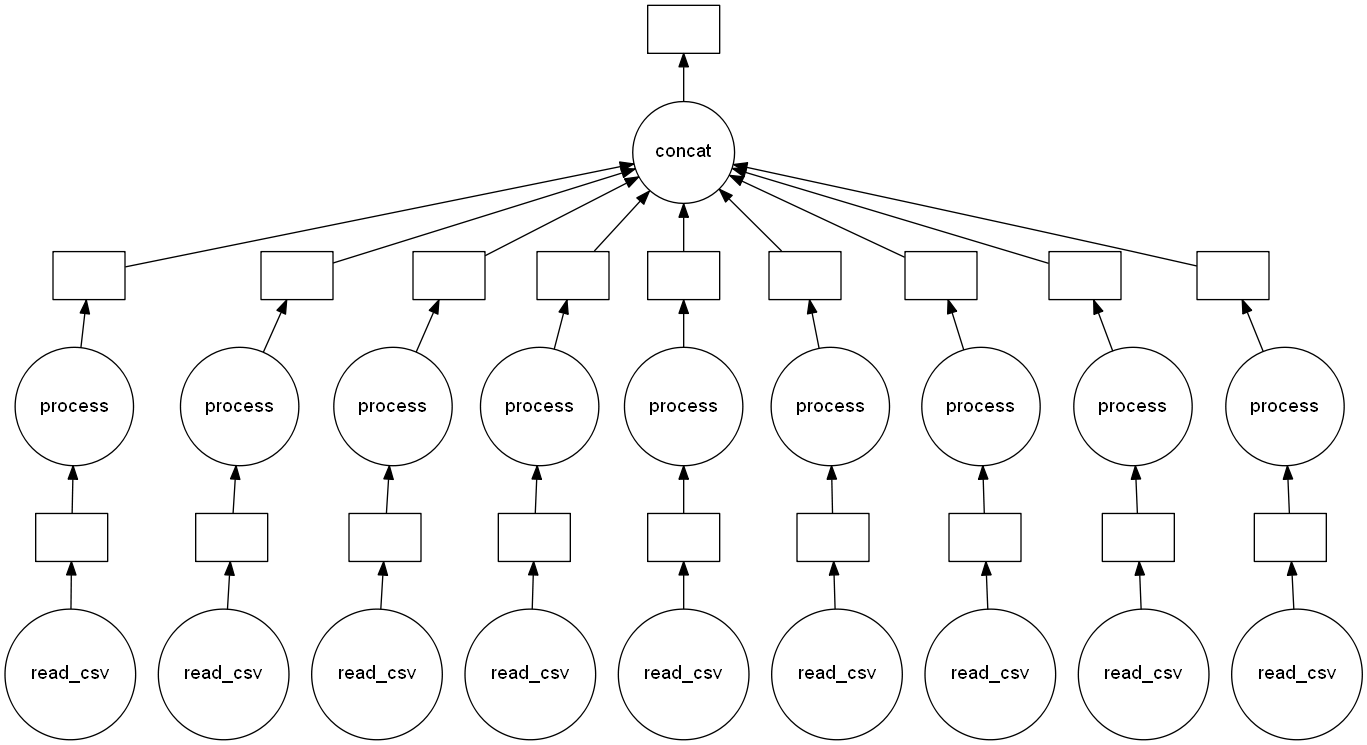

In [5]:
total.visualize()

In [6]:
compile_df = total.compute()

In [7]:
compile_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80412096 entries, 0 to 4997039
Data columns (total 4 columns):
 #   Column  Dtype         
---  ------  -----         
 0   井名      object        
 1   井號      object        
 2   水位(m)   object        
 3   日期時間    datetime64[ns]
dtypes: datetime64[ns](1), object(3)
memory usage: 3.0+ GB


In [8]:
compile_df.to_csv('data/database_wl_before2019_{}.csv'.format(date), index=False)

In [ ]:
client.close()

## 2019
In the folders naming 1, 2, 3...The csv is by each station.

In [ ]:
csv = 'data/1/二龍觀一(02050311)_20210405205125.csv'
X = pd.read_csv(csv, encoding='big5', skiprows=2)
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52559 entries, 0 to 52558
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   日期時間    52559 non-null  object 
 1   地下水位    52559 non-null  float64
dtypes: float64(1), object(1)
memory usage: 821.4+ KB


In [ ]:
X.head()

,日期時間,地下水位
0,2019-01-01 00:00:00,0.938
1,2019-01-01 00:10:00,0.944
2,2019-01-01 00:20:00,0.946
3,2019-01-01 00:30:00,0.951
4,2019-01-01 00:40:00,0.955


In [2]:
from dask import delayed
from dask.distributed import Client
client = Client(memory_limit='25GB')

In [3]:
def read_csv(csv):
    return pd.read_csv(csv, encoding='big5', dtype=object, skiprows=2)

def process(csv, df):
    well_name, well_no = csv.split('\\')[-1].split(')_')[0].split('(')
    df['井名'] = np.repeat(well_name, len(df))
    df['井號'] = np.repeat(well_no, len(df))
    return df

def concat(compile_list):
    return pd.concat(compile_list, axis=0, join='outer')

compile_list = []
# the folders are list from 1 to 10
for i in range(1, 11):
    for csv in glob.glob('data\\{}\\*'.format(i)):
        df = delayed(read_csv)(csv)
        X = delayed(process)(csv, df)
        compile_list.append(X)
total = delayed(concat)(compile_list)

In [4]:
len(compile_list)

765

In [5]:
total.visualize(filename='results/wl_2019.svg')

In [6]:
compile_df = total.compute()

In [7]:
compile_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36712682 entries, 0 to 43491
Data columns (total 6 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   日期時間    object
 1   地下水位    object
 2   井名      object
 3   井號      object
 4   水溫      object
 5   電導度     object
dtypes: object(6)
memory usage: 1.9+ GB


In [8]:
# change 地下水位 to 水位 (m)
compile_df.columns = ['日期時間', '水位(m)', '井名', '井號', '水溫', '電導度']

In [11]:
print('There are {} 電導度 measurements.'.format(len(compile_df) - compile_df['電導度'].isna().sum()))
print('There are {} measurments in this format.'.format(len(compile_df)))

There are 10055413 電導度 measurements.
There are 36712682 measurments in this format.


In [9]:
print(compile_df['日期時間'].min())
print(compile_df['日期時間'].max())

2019-01-01 00:00:00
2019-12-31 23:50:00


In [10]:
# Only export these 4 coulmns for the consistency
compile_df[['井號', '井名', '日期時間', '水位(m)']].to_csv('data/database_wl_2019_{}.csv'.format(date), index=False)

In [12]:
client.close()

## 2020-2021
The csv files naming GW_202XXX. Downloaded 及時地下水 from https://gweb.wra.gov.tw/Hydroinfo/downloadpage/#.

In [ ]:
X = pd.read_csv('data/GW_20202.csv', encoding='big5')
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3199244 entries, 0 to 3199243
Data columns (total 7 columns):
 #   Column    Dtype  
---  ------    -----  
 0   管理單位      object 
 1   地下水分區     object 
 2   井號        int64  
 3   井名        object 
 4   井頂高程(m)   float64
 5   觀測時間      object 
 6   地下水位高(m)  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 170.9+ MB


In [ ]:
X.head()

,管理單位,地下水分區,井號,井名,井頂高程(m),觀測時間,地下水位高(m)
0,第十河川局,臺北盆地,1010212,十工處(1),10.435,2020-02-01 00:00,-1.357
1,第十河川局,臺北盆地,1010212,十工處(1),10.435,2020-02-01 00:10,-1.358
2,第十河川局,臺北盆地,1010212,十工處(1),10.435,2020-02-01 00:20,-1.358
3,第十河川局,臺北盆地,1010212,十工處(1),10.435,2020-02-01 00:30,-1.357
4,第十河川局,臺北盆地,1010212,十工處(1),10.435,2020-02-01 00:40,-1.359


In [ ]:
from dask import delayed
from dask.distributed import Client
client = Client(memory_limit='25GB')

In [ ]:
def read_csv(csv):
    return pd.read_csv(csv, encoding='big5', dtype=object)

# no need of process

def concat(compile_list):
    return pd.concat(compile_list, axis=0, join='outer')

compile_list = []

# the csv are stored in the first level of data folder 
for csv in glob.glob('data\\GW*.csv'):
    df = delayed(read_csv)(csv)
    compile_list.append(df)
total = delayed(concat)(compile_list)

In [ ]:
len(compile_list)

21

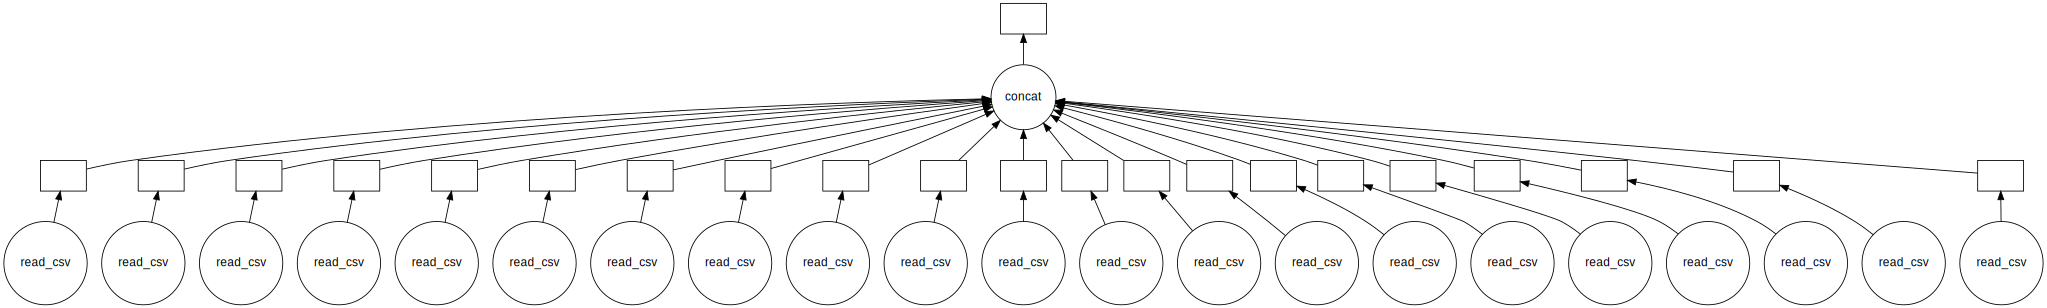

In [ ]:
total.visualize(filename='results/wl_a2020.svg')

In [ ]:
compile_df = total.compute()

In [ ]:
compile_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67060172 entries, 0 to 2282160
Data columns (total 7 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   管理單位      object
 1   地下水分區     object
 2   井號        object
 3   井名        object
 4   井頂高程(m)   object
 5   觀測時間      object
 6   地下水位高(m)  object
dtypes: object(7)
memory usage: 4.0+ GB


In [ ]:
compile_df.columns

Index(['管理單位', '地下水分區', '井號', '井名', '井頂高程(m)', '觀測時間', '地下水位高(m)'], dtype='object')

In [ ]:
# change 地下水位高(m) to 水位(m)
# change 觀測時間 to 日期時間
compile_df.columns = ['管理單位', '地下水分區', '井號', '井名', '井頂高程(m)', '日期時間', '水位(m)']

In [ ]:
print(compile_df['日期時間'].min())
print(compile_df['日期時間'].max())

2020-01-01 00:00
2021-09-22 00:00


In [ ]:
# Only export these 4 coulmns for the consistency
compile_df[['井號', '井名', '日期時間', '水位(m)']].to_csv('data/database_wl_a2019_{}.csv'.format(date), index=False)